In [131]:
import numpy as np
import matplotlib.pyplot as plt

#Arbitrary sequence
temperatures = np.array([32.1, 33.5, 34.5, 32.9, 33.0, 33.6, 33.1, 32.4])
x_train = temperatures[:-1]
y_train = temperatures[-1]

#General Layer class
class Layer:

	def __init__(self):
		self.input = None
		self.output = None

	def forward(self, input):

		pass


	def backward(self, output_grad, learning_rate):

		pass

#Mean squared error
def mse(y_true, y_pred):
	return np.mean((y_true - y_pred)**2)

def mse_prime(y_true, y_pred):
	return 2 * (y_pred - y_true)/np.size(y_true)

class RNN(Layer):
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.Wx = np.random.randn(hidden_size, input_size) # Weights relative to input
        self.Wh = np.random.randn(hidden_size, hidden_size)  # Weights relative to hidden states
        self.Wy = np.random.randn(output_size, hidden_size)  # Weights relative to output
        self.bh = np.zeros((hidden_size, 1)) #Bias relative to activation
        self.by = np.zeros((output_size, 1)) #Bias relative to output

    def forward(self, inputs):
        self.inputs = inputs
        self.hidden_states = []
        
        h_old = np.zeros((self.hidden_size, 1))
        for x in inputs:
            h = np.tanh(np.dot(self.Wx, x) + np.dot(self.Wh, h_old) + self.bh) # Using tanh
            y = np.dot(self.Wy, h) + self.by       
            self.hidden_states.append(h)
            h_old = h
            
        return y[-1,-1] # Original y is a matrix (something like 1x10); We want last value from the vector

    def backward(self, output_grad, learning_rate):
        dWx, dWh, dWy, dbh, dby, dh_new = np.zeros_like(self.Wx), np.zeros_like(self.Wh), np.zeros_like(self.Wy), np.zeros_like(self.bh), np.zeros_like(self.by), np.zeros_like(self.bh)
        
        for t in reversed(range(len(self.inputs))):
            x = self.inputs[t]
            h = self.hidden_states[t]
            dy = output_grad
            
            dWy += np.sum(np.dot(dy, h.T), axis = 0, keepdims=True) #Initially with different shapes; So needed to do this
            dby += np.sum(dy)
            
            dh = np.dot(self.Wy.T, dy) + dh_new
            dh_grad = (1 - h * h) * dh # derivative of tanh
            dbh += np.sum(dh_grad.T, axis=0, keepdims=True).T #Initially with different shapes; So needed to do this

            
            dWx += np.dot(dh_grad, x.T)
            dWh += np.dot(dh_grad, self.hidden_states[t - 1].T)
            dh_out = np.dot(self.Wh.T, dh_grad)
        
        
        self.Wx -= learning_rate * dWx
        self.Wh -= learning_rate * dWh
        self.Wy -= learning_rate * dWy
        self.bh -= learning_rate * dbh
        self.by -= learning_rate * dby
        
        return dh_out

def predict(network, input):
	output = input 
	for layer in network:
		output = layer.forward(output)

	return output

def train(network, loss, loss_prime, x_train, y_train,
          epochs=10, learning_rate=0.01, verbose=True):


    predic_labels = []
    for e in range(epochs):
        training_loss = 0   
        
        # Forward pass
        output = predict(network, x_train)
        predic_labels.append(output)
        training_loss = loss(y_train, output)
        
        # Compute grad
        grad = loss_prime(y_train, output)
        
        # Backward pass
        for layer in reversed(network):
            grad = layer.backward(grad, learning_rate)
    

        if verbose:
            print(f"Epoch {e + 1}/{epochs}, Training Loss = {training_loss}")
            print(f"Predicted temperature: {output:.1f}, Real temperature: {y_train}")

    plt.plot(np.arange(1, epochs + 1), np.full(20, y_train), "k", label = "Temperature at $\\tau$")
    plt.plot(np.arange(1, epochs + 1), predic_labels, "r.", label = "Predicted temperature at $\\tau$")
    plt.xlabel("Epochs")
    plt.ylabel("Temperature value")
    plt.legend()
    

Epoch 1/20, Training Loss = 1329.5931772798451
Predicted temperature: -4.1, Real temperature: 32.4
Epoch 2/20, Training Loss = 25.106146955637445
Predicted temperature: 27.4, Real temperature: 32.4
Epoch 3/20, Training Loss = 0.06475613953054918
Predicted temperature: 32.7, Real temperature: 32.4
Epoch 4/20, Training Loss = 0.002337749765320635
Predicted temperature: 32.4, Real temperature: 32.4
Epoch 5/20, Training Loss = 8.439470338503661e-05
Predicted temperature: 32.4, Real temperature: 32.4
Epoch 6/20, Training Loss = 3.0467185789691177e-06
Predicted temperature: 32.4, Real temperature: 32.4
Epoch 7/20, Training Loss = 1.0998906098303428e-07
Predicted temperature: 32.4, Real temperature: 32.4
Epoch 8/20, Training Loss = 3.970696078507212e-09
Predicted temperature: 32.4, Real temperature: 32.4
Epoch 9/20, Training Loss = 1.4334541277779063e-10
Predicted temperature: 32.4, Real temperature: 32.4
Epoch 10/20, Training Loss = 5.174887973595301e-12
Predicted temperature: 32.4, Real tem

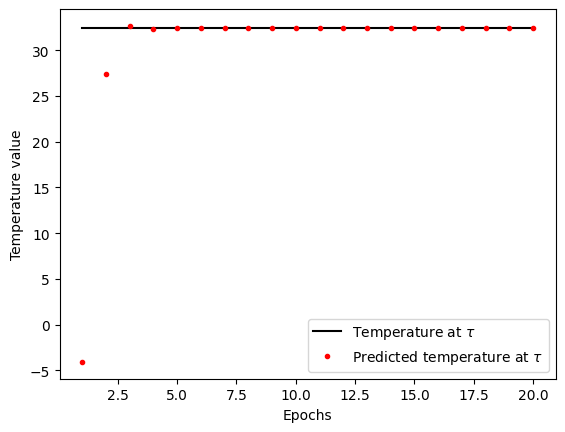

In [132]:
network = [RNN(len(x_train), 10, 1)]
train(network, mse, mse_prime, x_train, y_train, epochs = 20, learning_rate=0.005, verbose=True)